---

# The Perceptron Pocket Algorithm on MNIST Dataset

By: Laura Moses

---

Many instances of data are linearily seperable, but only after removing noise; the following image is one such example.

![Example of "Noise"](linear_noisy_data.png)

---

Such data is actually encountered often: even though a linear classifier seems appropiate, the data may not be linearily seperable because of outliers or noise. Notably, we proved that the perceptron learning algorithm (PLA) will not converge whenever the training data is not linearily seperable. Thus, we must exclude the PLA from our toolkit in this instance. More specifically, we need solve the combinatorial optimization problem:

$$
\min_{\boldsymbol{w}\in\mathbb{R}^{d+1}}\frac{1}{N}\sum_{i=n}^{N}||\text{sign}(w^{T}\boldsymbol{x}_n) \neq y_n||.
$$

Note the in-sample error is given by:
$$
E_{\text{in}}(\boldsymbol{w}) = \frac{1}{N}\sum_{i=n}^{N}||\text{sign}(w^{T}\boldsymbol{x}_n) \neq y_n||.
$$

---

In general, determining the solution the above mentioned optimization problemn is NP-hard. Thus, we will only approximate the solution the minimization problem. Our algorithm is called the pocket algorithm. Essentially, the pocket algorithm keeps in its 'pocket' the best weight vector encountered up to iteration $t$ in PLA. At the end of the algorithm, the best weight vector will be reported as the final hypothesis.

---

### The Pocket Algorithm

1. Set the pocket weight vector $\hat{\boldsymbol{w}}$ to $\boldsymbol{w}(0)$ of PLA.
1. for $t=0,\dots,T-1$ do
* Run PLA for one update to obtain $\boldsymbol{w}(t+1)$.
* Evaluate $E_{\text{in}}(\boldsymbol{w}(t+1))$.
* if $\boldsymbol{w}(t+1)$ is better than $\hat{\boldsymbol{w}}$ in terms of $E_{\text{in}}(\boldsymbol{w}(t+1))$, set $\hat{\boldsymbol{w}}$ to $\boldsymbol{w}(t+1)$.
1. Return $\hat{\boldsymbol{w}}$

The original PLA only checks some of the examples using $\boldsymbol{w}(t)$ to identify $(\boldsymbol{x}(t), y(t))$ in each iteration, while the pocket algorithm needs an additional step that evaluates all examples using $\boldsymbol{w}(t+1)$ to get $E_{\text{in}}(\boldsymbol{w}(t+1))$. This additional step makes the pocket algorithm much slower that PLA. Nevertheless, it is a useful algorithm to know about. We will next implement the pocket algorithm to classify hand written images of digits in $\{1,5\}$ from the famous *mnist data set.*

---

## MNIST Data Set
The MNIST data set consists of $70,000$ images of hand written digits, $60,000$ of which are typically used as labeled training examples, where the other $10,000$ are used for testing your learning model on. 

![MNIST Examples](MnistExamples.png)

---

To access this data set, as well as view the data as an image, we will need the following packages:
* MLDatasets [documentation](https://github.com/JuliaML/MLDatasets.jl)
* Images, Testimages, ImageMagicO [documentation](https://juliaimages.org/latest/)

Additionally, to run this code you will need: 
* Random [documentationra](https://docs.julialang.org/en/v1/stdlib/Random/)

In [1]:
using MLDatasets, Images, TestImages, Random

train_x, train_y = MNIST.traindata()
test_x,  test_y  = MNIST.testdata();

---

### The MNIST data structure

---

The  data structures train_x and test_x are stored as 3 dimensional tensors.

![3-D Tensor](order-3-tensor.png)

In [2]:
# Show the dimensions of the train_x tensor.
size(train_x)

(28, 28, 60000)

In [3]:
# Verify the dimensions of the training vector. This should match the depth of out training 
# tensor. 
size(train_y)

(60000,)

In [4]:
# Verify the the shape of the elements in the tensor slices.
train_x[:,:,1]

28×28 Array{N0f8,2} with eltype Normed{UInt8,8}:
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.216  0.533  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.675  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.071  0.886  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.671  0.992  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.118     0.859  0.992  0.831  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.141     0.992  0.992  0.529  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.369  …  0.992  0.992  0.518  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.604     0.992  0.957  0.063  0.0  0.0  0.0
 0.0  0.0  0.0 

Each image in the is comprised of a $28\times 28$ grey scaled grid of pixel values. These values are floating point numbers in the interval $(0,1)$, where darker pixels will have values closer to $1$ and lighter pixels will have values closer to $0$. The following image represents one such example.

![MNIST Matrix](MNIST-Matrix.png)

In [5]:
# What are the entries in each of these 28x28 matrices??
train_x[:,:,1]

28×28 Array{N0f8,2} with eltype Normed{UInt8,8}:
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.216  0.533  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.675  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.071  0.886  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.671  0.992  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.118     0.859  0.992  0.831  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.141     0.992  0.992  0.529  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.369  …  0.992  0.992  0.518  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.604     0.992  0.957  0.063  0.0  0.0  0.0
 0.0  0.0  0.0 

In [6]:
# Check the label of the above matrix. 
train_y[1]

5

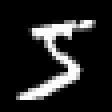

In [7]:
# View the image
colorview(Gray, train_x[:,:,1]')

---

### Implementing the Pocket Perceptron Algorithm

Now that we understand the data structure of the MNIST dataset, we can flatten the matrix into a 28-entry long feature vector in order to classify a subset of MNIST data. The following code uses the pocket perceptron algorithm to classify images of numbers in the set {1,5}. This is a binary classification problem, even though the input vectors have dimension much larger than typical.

---

In [8]:
# Use the pocket algorithm 
## to classify images of numbers in the set {1,5}

# Flatten the matrix
pocket_train_x = []
pocket_train_y = []
for i = 1:60000
    if train_y[i] == 1 || train_y[i] == 5
        push!(pocket_train_x, reshape(train_x[:,:,i], 784))
        push!(pocket_train_y, train_y[i] == 1 ? 1 : -1)
    end
end

# Sign Activation function
function sign(w, x)
    x = push!(copy(x), 1.0)
    return w'x > 0 ? 1 : -1
end

# Define the in-sample error
function errors(w)
    return sum([sign(w, pocket_train_x[i])!= pocket_train_y[i] ? 1 : 0 
            for i = 1:size(pocket_train_x)[1]])/size(pocket_train_x)[1]
end;

In [9]:
# Define the pocket algorithm on T iterations
function pocket_algorithm(T)
    w = randn(785)
    w_hat = copy(w)
    for i = 1:T
        for j = 1:size(pocket_train_x)[1]
            if sign(w, pocket_train_x[j]) != pocket_train_y[j]
                w += pocket_train_y[j]*push!(copy(pocket_train_x[j]),1.0)
            end
        end
        if errors(w) < errors(w_hat)
            w_hat = copy(w)
        end
    end
    return w_hat
end;

---

Now we are ready to try our functions:

---

In [10]:
# Let's try it!
w_new = pocket_algorithm(500); # these are our predicted weights

In [11]:
# Store indicies of 1's and 5'2
indicies = []
for i in 1:size(test_y)[1]
    if test_y[i] == 1 || test_y[i] == 5
        push!(indicies, (i, test_y[i]))
    end
end;

In [12]:
function check_value(i)
    println("Predicted value:", 
        sign(w_new, reshape(test_x[:,:,indicies[i][1]], 784)) == 1 ? 1 : 5, "\n")
    println("Labeled value:", test_y[indicies[i][1]], "\n")
    println("Image:")
    colorview(Gray, test_x[:,:,indicies[i][1]]')
end;

Predicted value:1

Labeled value:1

Image:


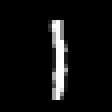

In [13]:
k = rand(1:length(indicies))
check_value(k)

Predicted value:1

Labeled value:1

Image:


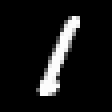

In [14]:
k = rand(1:length(indicies))
check_value(k)

Predicted value:1

Labeled value:1

Image:


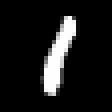

In [15]:
k = rand(1:length(indicies))
check_value(k)

Predicted value:1

Labeled value:1

Image:


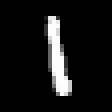

In [16]:
k = rand(1:length(indicies))
check_value(k)

Predicted value:1

Labeled value:1

Image:


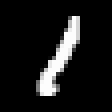

In [17]:
k = rand(1:length(indicies))
check_value(k)

Predicted value:5

Labeled value:5

Image:


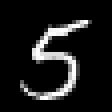

In [18]:
k = rand(1:length(indicies))
check_value(k)

Predicted value:5

Labeled value:5

Image:


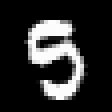

In [19]:
k = rand(1:length(indicies))
check_value(k)

Predicted value:5

Labeled value:5

Image:


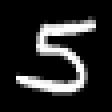

In [20]:
k = rand(1:length(indicies))
check_value(k)

Now that we've used our training data build our model weights, we want to measure the error rate of this algorithm. To do so I will be using the Classification Error method in which

$$Error = \frac{Number \space of \space incorrect \space predictions}{Total \space number \space of predictions \space made},$$

$$i.e. \space Error = \frac{1}{|D_{test}|} \sum_{i=1}^{|D_{test}|}[g(x^i)\neq y^i]$$

where $g(x_i)$ is the pocket algorithm predicted label (1 or 5) for a given feature $x^i$ in the `test_x` data set, and $y^i$ is the true corresponding label in the `test_y` data set. 

In [21]:
function predictor(w, X, indicies, i)
    return sign(w, reshape(X[:,:,indicies[i][1]], 784)) == 1 ? 1 : 5
end

function true_label(Y, indicies, i)
    return Y[indicies[i][1]]
end;

In [22]:
# define error_rate function 
function error_rate(X, Y, w, indicies)
    incorrect = 0
    for i = 1:length(indicies)
        if predictor(w, X, indicies, i) != true_label(Y, indicies, i)
            incorrect += 1
        end
    end
    e = incorrect / length(indicies)
    return e
end

error = error_rate(test_x, test_y, w_new, indicies)
accuracy = (1-error) * 100

99.25999013320178

---
### Conclusion

This means our pocket algorithm correctly classified $99.26\%$ of the 1's and 5's from the MNIST dataset. 

---